In [1]:
import numpy as np
import math

def func_constant_step_size(sub_gradient, iteration, diff_from_best_estimate):
    return 0.0004

def func_constant_step_length(sub_gradient, iteration, diff_from_best_estimate):
    global csl_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return 0.002 / np.sqrt(norm)
        
def func_square_summable_not_summable(sub_gradient, iteration, diff_from_best_estimate):
    return 3.0 / (iteration + 1)

def func_not_summable_diminishing_step_size(sub_gradient, iteration, diff_from_best_estimate):
    return 0.035 / np.sqrt(iteration + 1)

def func_not_summable_diminishing_step_length(sub_gradient, iteration, diff_from_best_estimate):
    global nsdsl_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return 0.19 / np.sqrt(norm * (iteration + 1))

def func_polyak_with_estimate(sub_gradient, iteration, diff_from_best_estimate):
    global polyak_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return (0.035 * norm / np.sqrt(iteration + 1) + diff_from_best_estimate) / norm

# Projected Subgradient Method

# Usage:
#   a_i, mse, v_opt, v_ij_opt = gdof (
#    N, M, 
#    joint_covariance, 
#    unknown_index_matrix)
#
# Inputs:
#   N - the input measurement count
#   M - the input measurement dimension
#   joint_covariance - the joint covariance matrix
#       for the all the measurements. It's a 4-d
#       tensor, with the first two dimensions
#       referring to the measurements and the last
#       two dimensions referring to the measurement
#       components. For unknown cross-correlation
#       matrices, the values are not used.
#   unknown_index_matrix - a bool numpy array.
#       the element of the matrix at
#       location (i,j) is set to be one if V_ij is unknown.
#       otherwise it is set to be zero.
#
# Outputs:
# . a_i - the matrix weights, a tensor of 3d, with the first
# .       dimension index being the measurement index
# . mse - the resulting mean square error
# . v_opt - the estimate covariance
#   v_ij_opt - the maximizing cross correlation matrix at (i,j)
def PSG(N, M, joint_covariance, unknown_index_matrix, step_func=func_constant_step_size, max_iteration=12000):
    assert (N, N, M, M) == joint_covariance.shape
    assert (N, N) == unknown_index_matrix.shape
    V = joint_covariance
    B = np.zeros((N, M, M), dtype=np.float32)
    Lambda_inv_sqrt = np.zeros((N,M), dtype=np.float32)
    U = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        Lambda_inv_sqrt[i], U[i] = np.linalg.eigh(joint_covariance[i, i])
        Lambda_inv_sqrt[i] = np.reciprocal(np.sqrt(Lambda_inv_sqrt[i]))
        B[i] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
    
    V_prime = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and (not unknown_index_matrix[i, j]):
                V_prime[i, j] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
                V_prime[i, j] = np.matmul(V_prime[i, j], V[i, j])
                V_prime[i, j] = np.matmul(V_prime[i, j], U[j])
                V_prime[i, j] = np.matmul(V_prime[i, j], np.diag(Lambda_inv_sqrt[j]))
    
    Sigma = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        Sigma = Sigma + np.linalg.inv(V[i, i])
    Sigma_inv = np.linalg.inv(Sigma)

    # initial A_prime values
    A_prime = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A_prime[i] = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i]))) / N

    epislon = 1.0e-12
    mse = np.finfo(np.float32).max
    mse_iteration = []
    mse_best = np.finfo(np.float32).max
    last_mse_diff = 0
    A_prime_best = np.zeros((N, M, M), dtype=np.float32)
    for iteration in range(max_iteration):

        # Get SVD of A[j]^T A[i]
        C = np.zeros((N, N, M, M), dtype=np.float32)
        D = np.zeros((N, N, M, M), dtype=np.float32)
        Lambda_ij = np.zeros((N, N, M), dtype=np.float32)
        for i in range(N):
            for j in range(N):
                if i != j and unknown_index_matrix[i, j]:
                    C[i, j], Lambda_ij[i, j], D[i, j] = np.linalg.svd(np.matmul(np.transpose(A_prime[j]), A_prime[i]))
                    D[i, j] = np.transpose(D[i, j]) # convention of python linalg library
                    
        # compute subgradients
        dA_prime = np.zeros((N, M, M), np.float32)
        for i in range(N):
            dA_prime[i] = A_prime[i]
            for j in range(N):
                if j != i:
                    if unknown_index_matrix[i, j]:
                        dA_prime[i] = dA_prime[i] + np.matmul(np.matmul(A_prime[j], C[i, j]), np.transpose(D[i, j]))
                    else:
                        dA_prime[i] = dA_prime[i] + np.matmul(A_prime[j], np.transpose(V_prime[i, j]))
            dA_prime[i] = dA_prime[i] * 2.0

        # apply step size & subgradient
        step = step_func(dA_prime, iteration, last_mse_diff)
        for i in range(N):
            A_prime[i] = A_prime[i] - dA_prime[i] * step
            
        # project onto the constraint hyperplanes
        A_prime_dot_B = np.zeros((M, M), np.float32)
        for i in range(N):
            A_prime_dot_B = A_prime_dot_B + np.matmul(A_prime[i], B[i])
        A_prime_dot_B_Sigma_inv = np.matmul(np.eye(M, dtype=np.float32) - A_prime_dot_B, Sigma_inv)
        for i in range(N):
            A_prime[i] = A_prime[i] + np.matmul(A_prime_dot_B_Sigma_inv, np.transpose(B[i]))

        # compute mse
        mse_prime = 0.0
        for i in range(N):
            mse_prime = mse_prime + np.trace(np.matmul(np.transpose(A_prime[i]), A_prime[i]))
        for i in range(N):
            for j in range(N):
                if i != j:
                    if unknown_index_matrix[i, j]:
                        _, sigmas, _ = np.linalg.svd(np.matmul(np.transpose(A_prime[j]), A_prime[i]))
                        mse_prime = mse_prime + np.sum(sigmas)
                    else:
                        mse_prime = mse_prime + np.trace(np.matmul(np.matmul(A_prime[i], V_prime[i, j]), np.transpose(A_prime[j])))
        
        mse_iteration.append(mse_prime)
        #print('mse: ', mse_prime, mse_best, sigmas, A_prime)
        if mse_prime < mse_best:
            mse_best = mse_prime
            A_prime_best = A_prime
            last_mse_diff = 0
        last_mse_diff = mse_prime - mse_best
    
    A = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A[i] = np.matmul(np.matmul(A_prime_best[i], np.diag(Lambda_inv_sqrt[i])), np.transpose(U[i]))
    V_ij_opt = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                C_ij, Lambda_ij, D_ij = np.linalg.svd(np.matmul(np.transpose(A_prime_best[j]), A_prime_best[i]))
                part_left = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i])))
                part_middle = np.matmul(np.transpose(D_ij), np.transpose(C_ij))
                part_right = np.matmul(np.diag(np.reciprocal(Lambda_inv_sqrt[j])), np.transpose(U[j]))
                V_ij_opt[i, j] = np.matmul(np.matmul(part_left, part_middle), part_right)
    V_opt = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V_ij_opt[i, j]), np.transpose(A[j]))
            else:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V[i, j]), np.transpose(A[j]))
    
    return A, mse_best, V_opt, V_ij_opt, mse_iteration

In [2]:
# Test case 1 from Spyridon Leonardos and Kostas Daniilidis
import time

x1 = np.array([0.0, 0.0], np.float32)
V11 = np.array([[5.0, 0], [0, 1.0]], np.float32)

x2 = np.array([0.0, 0.0], np.float32)
V22 = np.array([[2.0, 0], [0, 7.0]], np.float32)

x3 = np.array([0.0, 0.0], np.float32)
V33 = np.array([[4.0, 0], [0, 100.0]], np.float32)

joint_covariance = np.array([[V11, V11, V11],[V22, V22, V22], [V33, V33, V33]], np.float32)
unknown_index_matrix = np.array([[False, True, True], [True, False, True], [True, True, False]], dtype=bool)
N = 3
M = 2

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_css_iteration = PSG(N, M, joint_covariance, unknown_index_matrix)
css_elapsed_time = time.time() - start_time
print('CSS - Elapsed time: ', css_elapsed_time)
print('CSS - A_i: ', a_i)
print('CSS - MSE: ', mse)
print('CSS - Covariance: ', v_opt)
#print('CSS - Missing covariance matrics: ', v_ij_opt)

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_csl_iteration = PSG(N, M, joint_covariance, unknown_index_matrix, step_func=func_constant_step_length)
csl_elapsed_time = time.time() - start_time
print('CSL - Elapsed time: ', csl_elapsed_time)
print('CSL - A_i: ', a_i)
print('CSL - MSE: ', mse)
print('CSL - Covariance: ', v_opt)
#print('CSL - Missing covariance matrics: ', v_ij_opt)

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_ssns_iteration = PSG(N, M, joint_covariance, unknown_index_matrix, step_func=func_square_summable_not_summable)
ssns_elapsed_time = time.time() - start_time
print('SSNS - Elapsed time: ', ssns_elapsed_time)
print('SSNS - A_i: ', a_i)
print('SSNS - MSE: ', mse)
print('SSNS - Covariance: ', v_opt)
#print('SSNS - Missing covariance matrics: ', v_ij_opt)

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_nsdss_iteration = PSG(N, M, joint_covariance, unknown_index_matrix, step_func=func_not_summable_diminishing_step_size)
nsdss_elapsed_time = time.time() - start_time
print('NSDSS - Elapsed time: ', nsdss_elapsed_time)
print('NSDSS - A_i: ', a_i)
print('NSDSS - MSE: ', mse)
print('NSDSS - Covariance: ', v_opt)
#print('NSDSS - Missing covariance matrics: ', v_ij_opt)

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_nsdsl_iteration = PSG(N, M, joint_covariance, unknown_index_matrix, step_func=func_not_summable_diminishing_step_length)
nsdsl_elapsed_time = time.time() - start_time
print('NSDSL - Elapsed time: ', nsdsl_elapsed_time)
print('NSDSL - A_i: ', a_i)
print('NSDSL - MSE: ', mse)
print('NSDSL - Covariance: ', v_opt)
#print('NSDSL - Missing covariance matrics: ', v_ij_opt)

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_polyak_iteration = PSG(N, M, joint_covariance, unknown_index_matrix, step_func=func_polyak_with_estimate)
polyak_elapsed_time = time.time() - start_time
print('Polyak - Elapsed time: ', polyak_elapsed_time)
print('Polyak - A_i: ', a_i)
print('Polyak - MSE: ', mse)
print('Polyak - Covariance: ', v_opt)
#print('Polyak - Missing covariance matrics: ', v_ij_opt)

CSS - Elapsed time:  8.37242865562439
CSS - A_i:  [[[ 6.5183092e-04 -1.4767815e-05]
  [ 9.4172528e-06  1.0001100e+00]]

 [[ 9.9932522e-01  4.8632373e-06]
  [ 2.2705636e-07 -6.6922126e-05]]

 [[ 2.3023531e-05  9.9045856e-06]
  [-9.6443118e-06 -4.3042699e-05]]]
CSS - MSE:  3.0005169543989325
CSS - Covariance:  [[ 2.0017326  -0.01363561]
 [-0.01363561  1.0014362 ]]
CSL - Elapsed time:  9.072871923446655
CSL - A_i:  [[[ 4.6717047e-04 -6.2714425e-06]
  [ 2.6105621e-05  9.9983186e-01]]

 [[ 9.9953222e-01  1.5854992e-05]
  [ 5.1238799e-06  2.0941705e-04]]

 [[ 6.4275810e-07 -9.5835458e-06]
  [-3.1229501e-05 -4.1316976e-05]]]
CSL - MSE:  3.0005228139022933
CSL - Covariance:  [[ 2.0013547e+00 -3.7477817e-04]
 [-3.7477829e-04  1.0016078e+00]]
SSNS - Elapsed time:  8.293511152267456
SSNS - A_i:  [[[ 3.6540889e-04  3.6649853e-06]
  [-3.2532655e-06  9.9976718e-01]]

 [[ 9.9958152e-01 -3.0771812e-06]
  [ 8.9463983e-06  2.1226041e-04]]

 [[ 5.3108830e-05 -5.8780410e-07]
  [-5.6931331e-06  2.0588859e-

Text(0, 0.5, 'Execution time (s) (12K iterations)')

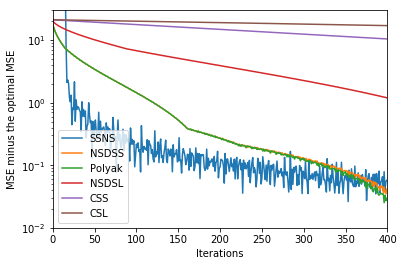

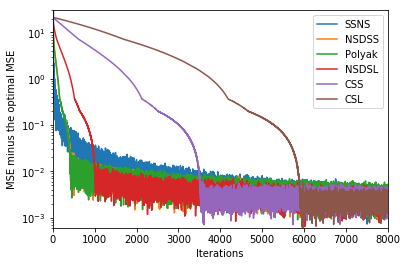

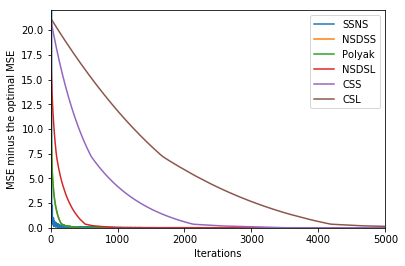

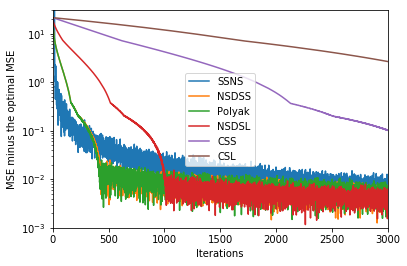

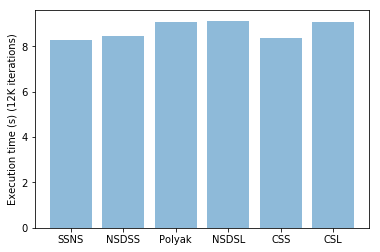

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.ylim((1.0e-2, 30.0))
plt.xlim((0.0, 400.0))
plt.yscale('log')
plt.plot(np.array(mse_ssns_iteration, dtype=np.float32) - 3.0, label="SSNS")
plt.plot(np.array(mse_nsdss_iteration, dtype=np.float32) - 3.0, label="NSDSS")
plt.plot(np.array(mse_polyak_iteration, dtype=np.float32) - 3.0, label="Polyak")
plt.plot(np.array(mse_nsdsl_iteration, dtype=np.float32) - 3.0, label="NSDSL")
plt.plot(np.array(mse_css_iteration, dtype=np.float32) - 3.0, label="CSS")
plt.plot(np.array(mse_csl_iteration, dtype=np.float32) - 3.0, label="CSL")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()

plt.figure()
plt.ylim((6.0e-4, 30.0))
plt.xlim((0.0, 8000.0))
plt.yscale('log')
plt.plot(np.array(mse_ssns_iteration, dtype=np.float32) - 3.0, label="SSNS")
plt.plot(np.array(mse_nsdss_iteration, dtype=np.float32) - 3.0, label="NSDSS")
plt.plot(np.array(mse_polyak_iteration, dtype=np.float32) - 3.0, label="Polyak")
plt.plot(np.array(mse_nsdsl_iteration, dtype=np.float32) - 3.0, label="NSDSL")
plt.plot(np.array(mse_css_iteration, dtype=np.float32) - 3.0, label="CSS")
plt.plot(np.array(mse_csl_iteration, dtype=np.float32) - 3.0, label="CSL")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()

plt.figure()
plt.ylim((1.0e-4, 22.0))
plt.xlim((0.0, 5000.0))
plt.plot(np.array(mse_ssns_iteration, dtype=np.float32) - 3.0, label="SSNS")
plt.plot(np.array(mse_nsdss_iteration, dtype=np.float32) - 3.0, label="NSDSS")
plt.plot(np.array(mse_polyak_iteration, dtype=np.float32) - 3.0, label="Polyak")
plt.plot(np.array(mse_nsdsl_iteration, dtype=np.float32) - 3.0, label="NSDSL")
plt.plot(np.array(mse_css_iteration, dtype=np.float32) - 3.0, label="CSS")
plt.plot(np.array(mse_csl_iteration, dtype=np.float32) - 3.0, label="CSL")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()

plt.figure()
plt.ylim((1.0e-3, 30.0))
plt.xlim((0.0, 3000.0))
plt.yscale('log')
plt.plot(np.array(mse_ssns_iteration, dtype=np.float32) - 3.0, label="SSNS")
plt.plot(np.array(mse_nsdss_iteration, dtype=np.float32) - 3.0, label="NSDSS")
plt.plot(np.array(mse_polyak_iteration, dtype=np.float32) - 3.0, label="Polyak")
plt.plot(np.array(mse_nsdsl_iteration, dtype=np.float32) - 3.0, label="NSDSL")
plt.plot(np.array(mse_css_iteration, dtype=np.float32) - 3.0, label="CSS")
plt.plot(np.array(mse_csl_iteration, dtype=np.float32) - 3.0, label="CSL")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()

plt.figure()
objects = ('SSNS', 'NSDSS', 'Polyak', 'NSDSL', 'CSS', 'CSL')
y_pos = np.arange(len(objects))
performance = [ssns_elapsed_time, nsdss_elapsed_time,polyak_elapsed_time,nsdsl_elapsed_time,css_elapsed_time,csl_elapsed_time]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Execution time (s) (12K iterations)')

Elapsed time:  3.471083402633667
A_i:  [[[1.9839931e-04 0.0000000e+00]
  [0.0000000e+00 9.9969399e-01]]

 [[9.9980152e-01 0.0000000e+00]
  [0.0000000e+00 3.0609121e-04]]]
MSE:  8.000014788412955
Covariance:  [[3.0003457 0.       ]
 [0.        5.0005608]]
Missing covariance matrics:  [[[[0.        0.       ]
   [0.        0.       ]]

  [[3.8729837 0.       ]
   [0.        5.9160795]]]


 [[[3.8729837 0.       ]
   [0.        5.9160795]]

  [[0.        0.       ]
   [0.        0.       ]]]]


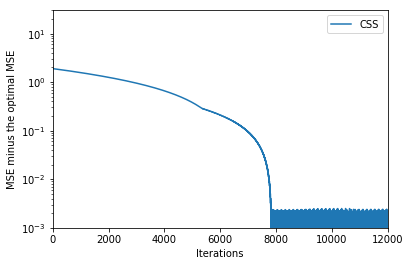

In [4]:
# Test case 1 from Spyridon Leonardos and Kostas Daniilidis
import time

x1 = np.array([0.0, 0.0], np.float32)
V11 = np.array([[5.0, 0], [0, 5.0]], np.float32)

x2 = np.array([0.0, 0.0], np.float32)
V22 = np.array([[3.0, 0], [0, 7.0]], np.float32)

joint_covariance = np.array([[V11, V11],[V22, V22]], np.float32)
unknown_index_matrix = np.array([[False, True], [True, False]], dtype=bool)
N = 2
M = 2
start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_iteration = PSG(N, M, joint_covariance, unknown_index_matrix)
elapsed_time = time.time() - start_time
print('Elapsed time: ', elapsed_time)
print('A_i: ', a_i)
print('MSE: ', mse)
print('Covariance: ', v_opt)
print('Missing covariance matrics: ', v_ij_opt)
plt.figure()
plt.ylim((1.0e-3, 30.0))
plt.xlim((0.0, 12000.0))
plt.yscale('log')
plt.plot(np.array(mse_iteration, dtype=np.float32) - 8.0, label="CSS")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()

Elapsed time:  3.4667718410491943
A_i:  [[[6.1160688e-05 0.0000000e+00]
  [0.0000000e+00 9.9999243e-01]]

 [[9.9993885e-01 0.0000000e+00]
  [0.0000000e+00 7.6281663e-06]]]
MSE:  6.000048905712902
Covariance:  [[1.0001512 0.       ]
 [0.        5.0010033]]
Missing covariance matrics:  [[[[ 0.        0.      ]
   [ 0.        0.      ]]

  [[ 2.236068  0.      ]
   [ 0.       70.71067 ]]]


 [[[ 2.236068  0.      ]
   [ 0.       70.71067 ]]

  [[ 0.        0.      ]
   [ 0.        0.      ]]]]


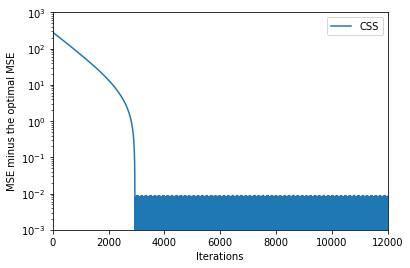

In [5]:
# Test case 2 from Spyridon Leonardos and Kostas Daniilidis
import time

x1 = np.array([0.0, 0.0], np.float32)
V11 = np.array([[5.0, 0], [0, 5.0]], np.float32)

x2 = np.array([0.0, 0.0], np.float32)
V22 = np.array([[1.0, 0], [0, 1000.0]], np.float32)

joint_covariance = np.array([[V11, V11],[V22, V22]], np.float32)
unknown_index_matrix = np.array([[False, True], [True, False]], dtype=bool)
N = 2
M = 2
start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_iteration = PSG(N, M, joint_covariance, unknown_index_matrix)
elapsed_time = time.time() - start_time
print('Elapsed time: ', elapsed_time)
print('A_i: ', a_i)
print('MSE: ', mse)
print('Covariance: ', v_opt)
print('Missing covariance matrics: ', v_ij_opt)
plt.figure()
plt.ylim((1.0e-3, 1000.0))
plt.xlim((0.0, 12000.0))
plt.yscale('log')
plt.plot(np.array(mse_iteration, dtype=np.float32) - 6.0, label="CSS")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()